In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.fft import fft2, ifft2
import torchvision
import torchvision.transforms as T
from torchvision import io
from torch.utils.data import Dataset, DataLoader

import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class Deconv2D(nn.Module):
    def __init__(self, shape=(2, 4)):
        super(Deconv2D, self).__init__()
        self.w_flat = nn.Parameter(data=torch.zeros(shape[0]*shape[1]-1),
                                   requires_grad=True)
        self.h_shape = shape

    def forward(self, x):
        w = nn.functional.pad(self.w_flat, (1, 0), value=1)

        w = torch.reshape(w, self.h_shape)
        
        hm1 = nn.functional.pad(w, (0, x.size(-1)-w.size(-1), 0, x.size(-2)-w.size(-2)))

        gm1f = 1/fft2(hm1)

        # gm2f = torch.flip(gm1f, (0,))
        # gm2f = torch.roll(gm1f, shifts=1, dims=0)

        # gm3f = torch.flip(gm1f, (1,))
        # gm3f = torch.roll(gm1f, shifts=1, dims=1)

        # gm4f = torch.flip(gm1f, (0, 1))
        # gm4f = torch.roll(gm1f, shifts=(1, 1), dims=(0,1))

        # gmf = gm1f*gm2f*gm3f*gm4f
        gmf = gm1f

        ymf = gmf*fft2(x)

        y = ifft2(ymf).real

        return y

In [4]:
cifar = torchvision.datasets.CIFAR100('cifar', download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting cifar/cifar-100-python.tar.gz to cifar


In [ ]:
# model = Deconv2D((6, 6))

model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train_model(model, criterion, optimizer, dataloader, num_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        running_loss= 0.0

        for X, y in dataloader:

            X = X.to(device)
            y = y.to(device)

            with torch.set_grad_enabled(True):
                outputs = model(X)
                loss = criterion(outputs, y)
                symmetry_penalty = torch.norm(model.w - model.w.t()) ** 2

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss

        if (epoch+1)%5 == 0:
            print('Epoch {:04d} loss: {:.5f}'.format(epoch+1, running_loss))

In [ ]:
train_model(model, criterion, optimizer, dataloader, num_epochs=100)

Epoch 0005 loss: 0.17930
Epoch 0010 loss: 0.17691
Epoch 0015 loss: 0.17552
Epoch 0020 loss: 0.17410
Epoch 0025 loss: 0.17279
Epoch 0030 loss: 0.17161
Epoch 0035 loss: 0.17056
Epoch 0040 loss: 0.16966
Epoch 0045 loss: 0.16889
Epoch 0050 loss: 0.16823
Epoch 0055 loss: 0.16765
Epoch 0060 loss: 0.16713
Epoch 0065 loss: 0.16666
Epoch 0070 loss: 0.16622
Epoch 0075 loss: 0.16582
Epoch 0080 loss: 0.16543
Epoch 0085 loss: 0.16507
Epoch 0090 loss: 0.16472
Epoch 0095 loss: 0.16440
Epoch 0100 loss: 0.16408


Text(0.5, 1.0, 'Original')

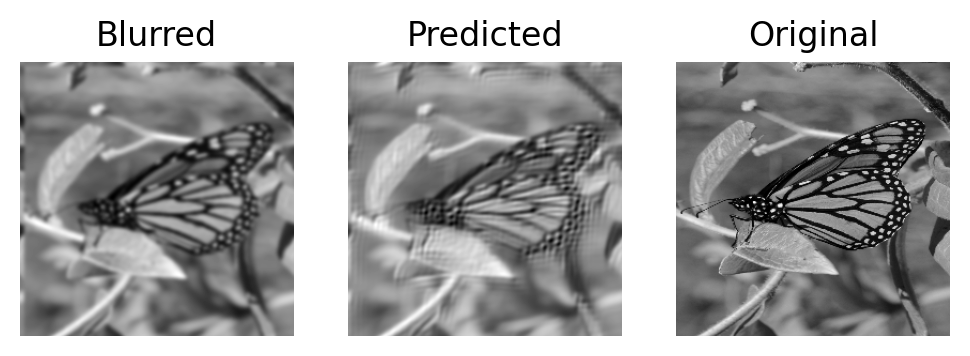

In [ ]:
model = model.to("cpu")
model.eval()
X, y = next(iter(dataloader))

y_pred = model(X)

import random

plt.rcParams['figure.dpi'] = 200
# plt.figure(figsize=(40, 120))

i = random.randint(0, len(X)-1)

start = X.size(-1)//4
end = 3*start

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
plt.imshow(X[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Blurred')

plt.subplot(1, 3, 2)
plt.imshow(y_pred[i,0,:,:].detach().numpy(), cmap='gray')
plt.axis('off')
plt.title('Predicted')

plt.subplot(1, 3, 3)
plt.imshow(y[i,0,:,:], cmap='gray')
plt.axis('off')
plt.title('Original')

In [ ]:
model.w_flat

Parameter containing:
tensor([-0.0266,  0.0041, -0.0125, -0.0339, -0.0508, -0.0586,  0.0414,  0.0492,
         0.0237,  0.0007, -0.0161, -0.0186,  0.0542,  0.0516,  0.0268,  0.0091,
        -0.0034, -0.0204,  0.0371,  0.0336,  0.0159,  0.0064, -0.0008, -0.0385,
         0.0117,  0.0126,  0.0039,  0.0021, -0.0013, -0.0607, -0.0135, -0.0067,
        -0.0074, -0.0040, -0.0062], requires_grad=True)